# Stats for the paper

```TODOs:```
- [x] For each system: average faithful, average gramm, average coverage
- [x] For each system: distribution over the merging categories (we’re mostly interested in the reference system)
- [x] For each MERGE CATEGORY: average faithful, average gramm (over all systems except reference)
  - Imbalanced concat: 90% faithful, 90% gramm
  - Replacement: 60% faithful, 95% gramm
  - Balanced concat: …
  - Other: …
- [x] Distribution over the merging categories (only on uncoverage summ sents -- consider a summ sent to be uncoverage if >= 51% of the responses were NO for coverage)
- [x] For each system: 3 summ sents that are unfaithful, 3 summ sents that are ungramm, 3 summ sents that are uncoverage


In [1]:
"""Gathers all statistics for paper and makes plots."""
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

processed = pd.read_csv("processed.csv")
processed.set_index(["Answer.article_hash", "WorkerId"], inplace=True)

tru_sys = ["Bottom-Up", "DCA", "PG", "Novel", "Fast-Abs-RL", "Reference"]
systems = ["bottom-up", "dca", "pg", "novel", "abs-rl-rerank", "reference"]
n_sys = len(systems)
n_exs = len(processed) * n_sys
eps = 1e-15

merge_d = {
    "Bal. Concat.": "bc",
    "Imbal. Concat.": "ic",
    "Replacement": "re",
    "Other": "ot",
}
rev_merge_d = {v: k for k, v in merge_d.items()}

sys_selec = [f"sys_{idx}" for idx in range(n_sys)]
grm_selec = [f"gramm_{idx}" for idx in range(n_sys)]
fth_selec = [f"faith_{idx}" for idx in range(n_sys)]
cvr_selec = [f"cover_{idx}" for idx in range(n_sys)]
mrg_selec = [f"merge_{idx}" for idx in range(n_sys)]
sum_selec = [f"summary_{idx}" for idx in range(n_sys)]
n_sys_sel = [f"n_{sys}" for sys in systems]

masks = {sys: (processed[sys_selec] == sys).values for sys in systems}
n_of = {sys: processed[f"n_{sys}"].sum() for sys in systems}

display(processed.head(n=1))
# display(processed.info())

,,Input.article_content,n_bottom-up,n_reference,n_dca,n_pg,n_novel,n_abs-rl-rerank,sys_0,sys_1,sys_2,...,summary_2,summary_3,summary_4,summary_5,sha_0,sha_1,sha_2,sha_3,sha_4,sha_5
Answer.article_hash,WorkerId,,,,,,,,,,,,,,,,,,,,,
ad7ae93a040c050c6264c5b1c55b6436503b34e406378689601c7dcc97f080e2,A1IZ4NX41GKU4X,(CNN) If you&apos;re famous and performing the...,0,1,3,1,1,0,dca,reference,pg,...,guitar slinger jimi hendrix inflamed mainstrea...,the crowd at the american league game would be...,the american national anthem will be a nationa...,the late night of the gulf war in the san dieg...,919603c3c8e2217d9afe6e7a407d27d296363a71f451f1...,c6fa2649470d5bc264f3b9e5fc182f2918be95b1034d4a...,f0f10dd0a9be8230cd858590b3614a9717678b7e7b0b38...,a01be3c29e2edcc91106bed254a773e8bad56d3c790cb4...,3fa58b9761027bd14d20b5f2a88563b9dc07fe1c966b26...,98ad3008c98e52919d633781fc00ac0ac82946761b9985...


In [2]:
print(n_of)

{'bottom-up': 554, 'dca': 492, 'pg': 143, 'novel': 648, 'abs-rl-rerank': 58, 'reference': 379}


In [3]:
n_summs = processed.reset_index().iloc[0][n_sys_sel].copy()
n_summs[:] = 0
for _, group in processed.reset_index().groupby("Answer.article_hash"):
    n_summs += group.iloc[0][n_sys_sel]
    
n_summs

n_bottom-up        146
n_dca              130
n_pg                37
n_novel            171
n_abs-rl-rerank     16
n_reference        100
Name: 0, dtype: object

---
## Averages

### Tabular output

In [4]:
averages = pd.DataFrame(columns=["system", "gramm", "faith", "cover"])
averages["system"] = systems
averages.set_index(["system"], inplace=True)

for sys in systems:
    averages.loc[sys, "gramm"] = (processed[grm_selec] * masks[sys]).sum().sum() / n_of[sys]
    averages.loc[sys, "faith"] = (processed[fth_selec] * masks[sys]).sum().sum() / n_of[sys]
    averages.loc[sys, "cover"] = (processed[cvr_selec] * masks[sys]).sum().sum() / n_of[sys]
    
averages.reset_index(inplace=True)
averages

,system,gramm,faith,cover
0,bottom-up,0.788809,0.568592,0.785199
1,dca,0.723577,0.469512,0.626016
2,pg,0.846154,0.769231,0.895105
3,novel,0.785494,0.584877,0.753086
4,abs-rl-rerank,0.775862,0.689655,0.827586
5,reference,0.915567,0.883905,0.74934


### Graphical output

In [5]:
averages.sort_values(by=["faith"], inplace=True)
display(averages)
sns_averages = pd.melt(averages, id_vars=["system"], value_vars=["faith", "gramm", "cover"],
                       var_name="metric", value_name="probability")
display(sns_averages)

,system,gramm,faith,cover
1,dca,0.723577,0.469512,0.626016
0,bottom-up,0.788809,0.568592,0.785199
3,novel,0.785494,0.584877,0.753086
4,abs-rl-rerank,0.775862,0.689655,0.827586
2,pg,0.846154,0.769231,0.895105
5,reference,0.915567,0.883905,0.74934


,system,metric,probability
0,dca,faith,0.469512
1,bottom-up,faith,0.568592
2,novel,faith,0.584877
3,abs-rl-rerank,faith,0.689655
4,pg,faith,0.769231
5,reference,faith,0.883905
6,dca,gramm,0.723577
7,bottom-up,gramm,0.788809
8,novel,gramm,0.785494
9,abs-rl-rerank,gramm,0.775862


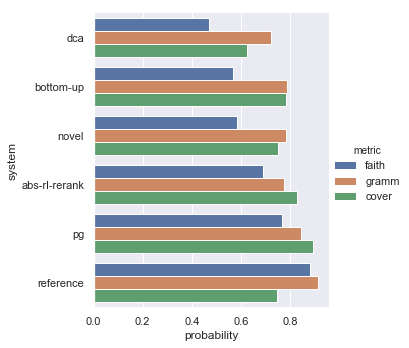

In [6]:
sns.set(style="darkgrid")
sns_averages_plot = sns.catplot(x="probability", y="system", hue="metric", data=sns_averages, kind="bar",)

sns_averages_plot.fig.savefig("averages.pdf")
sns_averages_plot

---
## Distribution over Merging

### Tabular output

In [7]:
merge_opts = list(merge_d.values())
merge_dist = pd.DataFrame(columns=["system"] + merge_opts)
merge_dist["system"] = systems
merge_dist.set_index(["system"], inplace=True)

# for sys, col in itertools.product(systems, merge_opts):
for sys, col in itertools.product(systems, merge_opts):
    merge_dist.loc[sys, col] = ((processed[mrg_selec] == col).values * masks[sys]).sum() / n_of[sys]

assert all(merge_dist.sum(axis=1) >= (1 - eps)), merge_dist.sum(axis=1)
merge_dist

,bc,ic,re,ot
system,,,,
bottom-up,0.315884,0.379061,0.111913,0.193141
dca,0.229675,0.365854,0.0934959,0.310976
pg,0.398601,0.405594,0.111888,0.0839161
novel,0.274691,0.382716,0.132716,0.209877
abs-rl-rerank,0.396552,0.344828,0.12069,0.137931
reference,0.313984,0.422164,0.0738786,0.189974


### Graphical output

,Bal. Concat.,Imbal. Concat.,Replacement,Other
system,,,,
Reference,0.313984,0.422164,0.0738786,0.189974
DCA,0.229675,0.365854,0.0934959,0.310976
Bottom-Up,0.315884,0.379061,0.111913,0.193141
Fast-Abs-RL,0.396552,0.344828,0.12069,0.137931
Novel,0.274691,0.382716,0.132716,0.209877
PG,0.398601,0.405594,0.111888,0.0839161


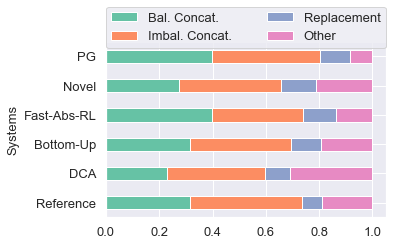

In [8]:
cp_mrg_dist = merge_dist.copy()

as_in_paper = ["PG", "Novel", "Fast-Abs-RL", "Bottom-Up", "DCA", "Reference"][::-1]

import matplotlib
matplotlib.rcParams["font.size"] = 22

with sns.color_palette("Set2"):
    cp_mrg_dist = cp_mrg_dist.rename(index={k: v for k, v in zip(systems, tru_sys)})
    cp_mrg_dist = cp_mrg_dist.reindex(as_in_paper)
    bc = cp_mrg_dist["bc"].values
    ic = cp_mrg_dist["ic"].values
    re = cp_mrg_dist["re"].values
    ot = cp_mrg_dist["ot"].values
    cp_mrg_dist = cp_mrg_dist.rename(columns=rev_merge_d)
    display(cp_mrg_dist)
    
    width = 0.45
    bc_plt = plt.barh(as_in_paper, bc, width)
    ic_plt = plt.barh(as_in_paper, ic, width, left=bc)
    re_plt = plt.barh(as_in_paper, re, width, left=bc + ic)
    ot_plt = plt.barh(as_in_paper, ot, width, left=bc + ic + re)
    
    fontsize = 13
    plt.ylabel("Systems", fontsize=fontsize)
    plt.tick_params(labelsize=fontsize)
    
    plt.legend((bc_plt[0], ic_plt[0], re_plt[0], ot_plt[0]), rev_merge_d.values(),
               bbox_to_anchor=(0., 1.1, 1., .1), ncol=2,  mode="expand", borderaxespad=0.,
               fontsize=fontsize)
    
    plt.tight_layout()
    plt.savefig(f"merge_dist-{fontsize}.pdf")

---
## Averages over Merging

### Tabular output

In [9]:
avg_over_merge = pd.DataFrame(columns=["merge", "gramm", "faith", "cover", "prob"])
avg_over_merge["merge"] = merge_opts
avg_over_merge.set_index(["merge"], inplace=True)

G_mask = (processed[grm_selec] == True)
F_mask = (processed[fth_selec] == True)
C_mask = (processed[cvr_selec] == True)

p_gramm = G_mask.sum().sum() / n_exs  # p(grammatical)
p_faith = F_mask.sum().sum() / n_exs  # p(faithful)
p_cover = C_mask.sum().sum() / n_exs  # p(covered)

for opt in merge_opts:
    mrg_mask = (processed[mrg_selec] == opt).astype(int)
    avg_over_merge.loc[opt, "prob"] = mrg_mask.sum().sum() / n_exs
    
    avg_over_merge.loc[opt, "gramm"] = (G_mask.values * mrg_mask.values).sum() / mrg_mask.sum().sum()
    avg_over_merge.loc[opt, "faith"] = (F_mask.values * mrg_mask.values).sum() / mrg_mask.sum().sum()
    avg_over_merge.loc[opt, "cover"] = (C_mask.values * mrg_mask.values).sum() / mrg_mask.sum().sum()
    
assert (avg_over_merge["gramm"] * avg_over_merge["prob"]).sum() - p_gramm <= eps
assert (avg_over_merge["faith"] * avg_over_merge["prob"]).sum() - p_faith <= eps
assert (avg_over_merge["cover"] * avg_over_merge["prob"]).sum() - p_cover <= eps

avg_over_merge

,gramm,faith,cover,prob
merge,,,,
bc,0.869173,0.825564,0.944361,0.292436
ic,0.802511,0.694064,0.84589,0.385224
re,0.820408,0.530612,0.77551,0.10774
ot,0.682377,0.252049,0.270492,0.2146


### Graphical output

/Users/ionlights/.conda/envs/correctness-cpu/lib/python3.6/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


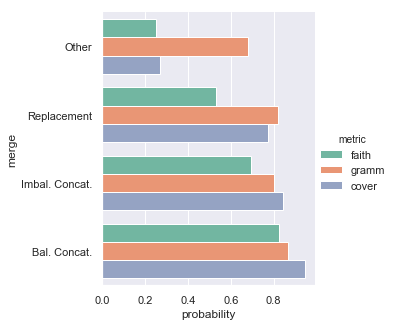

In [10]:
avg_over_merge_plot = avg_over_merge.drop(columns=["prob"]).reset_index().sort_values(by=["faith"])
avg_over_merge_plot = pd.melt(avg_over_merge_plot, id_vars=["merge"], value_vars=["faith", "gramm", "cover"],
                              var_name="metric", value_name="probability")
avg_over_merge_plot["merge"] = avg_over_merge_plot["merge"].map(rev_merge_d)

with sns.color_palette("Set2"):
    sns_avg_over_merge_plot = sns.catplot(x="probability", y="merge", hue="metric",
                                          data=avg_over_merge_plot, size=5, kind="bar")
    sns_avg_over_merge_plot.fig.savefig("avg_over_merge.pdf")
    sns_avg_over_merge_plot

---
## Distribution over Merging for `[unfaithful, ungrammatical, uncoverage]`

### Tabular output

In [11]:
# Distribution over the merging categories (only on uncoverage summ sents -- consider a summ sent to be 
# uncoverage if >= 51% of the responses were NO for coverage)
idx_mask = np.arange(start=1, stop=n_sys + 1)
def merge_dist_for(cols: list):
    df = pd.DataFrame(columns=["merge"])
    df["merge"] = merge_opts
    df.set_index(["merge"], inplace=True)
    df["count"] = 0
    df["total"] = [(processed[mrg_selec] == opt).sum().sum() for opt in merge_opts]
    df["percent"] = 0.
    
    mask = np.empty_like(processed[sys_selec])
    idx = 0
    for article, responses in processed.groupby("Answer.article_hash"):
        un_cols = ((1 - responses[cols].mean().values) > 0.5) * idx_mask - 1
        
        off = responses.shape[0]
        mask[idx:(idx + off)] = np.tile(un_cols, reps=off).reshape(off, n_sys)
        idx += off
        
        selects = [v for v in un_cols if v > -1]
        df_sele = responses.iloc[0][mrg_selec].values[selects]
        df.loc[df_sele, "count"] += 1
        
    df["percent"] = df["count"] / df["total"]
        
    return df, mask

from IPython.display import Markdown

display(Markdown("### Unfaithful"))
merge_dist_unfaith, mask_unfaith = merge_dist_for(fth_selec)
display(merge_dist_unfaith)

display(Markdown("### Ungrammatical"))
merge_dist_ungramm, mask_ungramm = merge_dist_for(grm_selec)
display(merge_dist_ungramm)

display(Markdown("### Uncoverage"))
merge_dist_uncover, mask_uncover = merge_dist_for(cvr_selec)
display(merge_dist_uncover)

### Unfaithful

,count,total,percent
merge,,,
bc,20,665,0.030075
ic,42,876,0.047945
re,19,245,0.077551
ot,39,488,0.079918


### Ungrammatical

,count,total,percent
merge,,,
bc,11,665,0.016541
ic,17,876,0.019406
re,5,245,0.020408
ot,16,488,0.032787


### Uncoverage

,count,total,percent
merge,,,
bc,8,665,0.012030
ic,16,876,0.018265
re,6,245,0.024490
ot,27,488,0.055328


### Graphical output

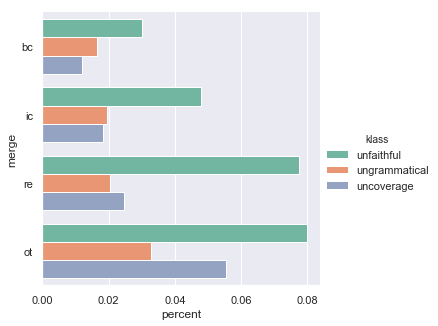

In [12]:
merge_dist_uns = pd.DataFrame(columns=["merge", "klass", "percent"])
merge_dist_uns["merge"] = merge_opts * 3
merge_dist_uns["klass"] = ["unfaithful"] * 4 + ["ungrammatical"] * 4 + ["uncoverage"] * 4
percents = list(merge_dist_unfaith["percent"]) + list(merge_dist_ungramm["percent"]) + list(merge_dist_uncover["percent"])
merge_dist_uns["percent"] = percents

# merge_dist_unfaith.plot(kind="barh", y="percent")
# merge_dist_uncover.plot(kind="barh", y="percent")
# merge_dist_ungramm.plot(kind="barh", y="percent")

with sns.color_palette("Set2"):
    sns_merge_dist_uns = sns.catplot(kind="bar", y="merge", x="percent", hue="klass", data=merge_dist_uns)
    sns_merge_dist_uns.fig.savefig("merge_dist_uns.pdf")

---
## 3 Examples (per system) of `[unfaithful, ungrammatical, uncoverage]`

In [13]:
# TODO: rework to be able to select out exact examples
from IPython.display import HTML

np.random.seed(42)

sha_selec = [f"sha_{idx}" for idx in range(n_sys)]
inp_selec = [f"src_{idx}" for idx in range(n_sys)]

sys_srcs = processed[inp_selec].values
sys_summ = processed[sum_selec].values
articles = processed["Input.article_content"].values

def sample_un_exs(sys: str, n: int = 3):
    display(Markdown(f"---\n## {sys}"))
    for name, uncat in zip(["unfaithful", "ungrammatical", "uncoverage"],
                           [mask_unfaith, mask_ungramm, mask_uncover]):
        display(Markdown(f"### {name}"))
        
        mask = (processed[sha_selec] * (uncat > 0) * masks[sys]).values
        mask = mask.flatten()
        mask_range = np.arange(0, len(mask))
        sha256s = []
        # really terrible implementation, but not sure how else to
        #   guarantee it can be reversed.
        track, catch = 0, n_sys * 0.5 * len(processed)
        for _ in range(n):
            while True:
                choice = np.random.choice(mask_range, size=1)
                if mask[choice] != "" and choice not in sha256s:
                    sha256s.append(choice)
                    break
                track += 1
                if track > catch:
                    break
            if track > catch:
                break

        for sha_idx in sha256s:
            row, col = sha_idx // n_sys, sha_idx % n_sys
            article = articles[row][0].split("||")
            lookups = sorted(list(map(int, sys_srcs[row, col][0].split(","))))
            display(Markdown(f"**{sys_summ[row, col][0]}**"))
            for look in lookups:
                display(Markdown(f"- **source** _[{look}]_: {article[look]}"))

for sys in systems:
    sample_un_exs(sys)

---
## bottom-up

### unfaithful

**man-of-the-moment harry kane of tottenham and england sold him to wolves.**

- **source** _[2]_: Stand up and take a bow anyone who came up with Benik Afobe, who was one of Arsenal&apos;s own before they loaned him to MK Dons and sold him to Wolves.

- **source** _[3]_: Afobe is young, electric-paced and on 28 goals this season - one behind man-of-the-moment Harry Kane of Tottenham and England.

**casey and justin rose will be three shots behind the leaders.**

- **source** _[4]_: It was a decent achievement in itself to make the halfway cut, and it earned him a third round draw alongside two rather more famous Englishmen in Paul Casey and Justin Rose.

- **source** _[5]_: Kelvin Day is three shots behind the leaders and remains in with a chance of making the Masters.

**peter greste&apos;s military commemoration has become a key game for australia.**

- **source** _[6]_: The man is Peter Greste.

- **source** _[10]_: There is nothing intrinsically wrong with military commemoration that honors the dead.

### ungrammatical

**philippe senderos and kieran richardson are doubts along with scott sinclair and ashley westwood.**

- **source** _[5]_: Alan Hutton limped off in Saturday&apos;s 3-1 defeat at Manchester United with an ankle problem and has been ruled out of Tuesday&apos;s game along with Scott Sinclair and Ashley Westwood.

- **source** _[7]_: Philippe Senderos and Kieran Richardson (both calf) are doubts along with Tom Cleverley (adductor) and Aly Cissokho (groin) - although they are training - while Libor Kozak is sidelined as he continues to recover from a broken leg.

**&quot;the gap is even greater for women of color,&quot; clinton says.**

- **source** _[3]_: And the gap is even greater for women of color.

- **source** _[16]_: &quot;Everyday Americans need a champion,&quot; Clinton said in her campaign launch video, &quot;and I want to be that champion.&quot;

**jordan henderson lost the ball 23 times in liverpool&apos;s 1-0 win over newcastle.**

- **source** _[4]_: Jordan Henderson (left) toiled as a wing back in Liverpool&apos;s defeat against Arsenal and lost the ball 23 times.

- **source** _[12]_: John O&apos;Shea only sprinted 11.9 metres during his impressive display in Sunderland&apos;s 1-0 win over Newcastle.

### uncoverage

**jordan henderson lost the ball 23 times in liverpool&apos;s 1-0 win over newcastle.**

- **source** _[4]_: Jordan Henderson (left) toiled as a wing back in Liverpool&apos;s defeat against Arsenal and lost the ball 23 times.

- **source** _[12]_: John O&apos;Shea only sprinted 11.9 metres during his impressive display in Sunderland&apos;s 1-0 win over Newcastle.

**phil mickelson will end the masters at augusta next week.**

- **source** _[4]_: Phil Mickelson capped his resurgence in form at the Houston Open with rounds of 66 or 67.

- **source** _[6]_: Tiger Woods confirmed his participation at The Masters at Augusta next week.

**iranian foreign minister javad zarif: &quot;long live zarif&quot;**

- **source** _[15]_: Iranian foreign minister Javad Zarif -- who led the Iranian negotiation team -- received a hero&apos;s welcome as he arrived in Iran on a sunny Friday morning.

- **source** _[16]_: &quot;Long live Zarif,&quot; crowds chanted as the vehicle rolled slowly down the packed street, carrying the man who struck the historic deal.

---
## dca

### unfaithful

**gray&apos;s death has led to the internet calling graham #motheroftheyear &quot; not at all &quot;. &quot;**

- **source** _[3]_: The video of Graham yanking her son, Michael Singleton, and slapping him with a right hand as CNN affiliate WMAR recorded has led to the Internet calling Graham #motheroftheyear.

- **source** _[13]_: Gray&apos;s death has sparked daily protests over police brutality.

**the big bopper, &quot; n - word, &quot; the american pie, &quot; says mclean&apos;s&apos; american pie.**

- **source** _[0]_: (CNN) &quot;A long, long, time ago...&quot; Those five words, when uttered or sung, makes baby boomers immediately think of Don McLean&apos;s pop masterpiece &quot;American Pie.&quot;

- **source** _[5]_: McLean was a paperboy when, on February 3, 1959, he saw that Buddy Holly, Ritchie Valens and J.P. &quot;The Big Bopper&quot; Richardson had been tragically killed in an airplane crash in Clear Lake, Iowa.

**woods reportedly shot 74 with a round of 66 with a 67 at the masters.**

- **source** _[4]_: Phil Mickelson capped his resurgence in form at the Houston Open with rounds of 66 or 67.

- **source** _[19]_: Woods reportedly shot a round of 74 in practice at Augusta on Tuesday and had a return of the chipping yips.

### ungrammatical

**alan hutton has been ruled out of tuesday&apos;s game against aston villa.**

- **source** _[3]_: Aston Villa.

- **source** _[5]_: Alan Hutton limped off in Saturday&apos;s 3-1 defeat at Manchester United with an ankle problem and has been ruled out of Tuesday&apos;s game along with Scott Sinclair and Ashley Westwood.

**england beat china 2 - 1 in the premier league on the day of the world cup.**

- **source** _[6]_: Kirby, a 21-year-old playing in the second division of the Women&apos;s Super League, was impressive throughout, a nimble-footed presence who China struggled to deal with.

- **source** _[16]_: This was England&apos;s last home game before Mark Sampson&apos;s squad head to Canada in May, ahead of a World Cup campaign that begins against France in Moncton on June 9.

**surrey - born kelvin day has only played a handful of events on the pga tour event.**

- **source** _[1]_: Surrey-born Kelvin Day has only played a handful of events on the subsidiary circuit, the Web.com Tour but decided to enter qualifying for the Houston event.

- **source** _[9]_: But it is worth bearing in mind that a victory would not only earn him a PGA Tour card but the last spot in the field for Augusta.

### uncoverage

**manchester united beat manchester united 2 - 1 in the champions league.**

- **source** _[1]_: Prior to the international break the Reds&apos; 13-match unbeaten league run was ended at home to Champions League-chasing rivals Manchester United, leaving them five points adrift of the qualification places.

- **source** _[17]_: &apos;The key for us in the first-half against Manchester United was that we did n&apos;t keep the ball well enough and, positionally, we were never in position to receive the ball and press the ball.

**qpr are without a trio of key players for their premier league clash.**

- **source** _[4]_: Aston Villa boss Tim Sherwood is definitely without a trio of key players for their key game with QPR.

- **source** _[10]_: QPR are without Chilean winger Eduardo Vargas and South Korean left-back Yun Suk-young for Tuesday&apos;s Barclays Premier League clash at Aston Villa.

**gerardo martino&apos;s side beat ecuador 4 - 2 in a friendly on saturday.**

- **source** _[1]_: Gerardo Martino&apos;s Argentina, with captain Messi looking on again while he nurses a right foot injury, had beaten El Salvador 2-0 in Washington on Saturday.

- **source** _[21]_: Mexico, who beat Ecuador on Friday, also had their second consecutive win by beating Paraguay with a goal from Eduardo Herrera in the third minute at the Arrowhead in Kansas City.

---
## pg

### unfaithful

**zarif says iran has made significant progress over the last few days.**

- **source** _[9]_: &quot;We have made significant progress over the last few days, but it has been slow going,&quot; British Foreign Secretary Philip Hammond told reporters Wednesday.

- **source** _[30]_: According to an IRNA report, Zarif said only that he hopes a framework agreement will be drafted Wednesday.

**radamel falcao has been in good goalscoring form for manchester united.**

- **source** _[4]_: River Plate are keen to sign former forward Radamel Falcao who has struggled on loan at Manchester United.

- **source** _[6]_: However, Falcao has been in good goalscoring form for his countrythis week, finding the net three times in two games to equal Colombia&apos;s all-time goalscoring record with 24 goals.

**iran has shown &quot;its readiness to engage with dignity,&quot; the iranian minister says.**

- **source** _[13]_: Zarif told reporters that Iran has shown &quot;its readiness to engage with dignity, and it&apos;s time for our negotiating partners to seize the moment and use this opportunity, which may not be repeated.&quot;

- **source** _[15]_: They are mutually exclusive,&quot; the Iranian minister said.

### ungrammatical

**but it was enough to defeat west ham in a frenetic match and breathe life back into the 86th minute of saturday&apos;s match it was by no means his most spectacular, a mere flick from six yards out enough to take the ball past adrian.**

- **source** _[1]_: Coming in the 86th minute of Saturday&apos;s match it was by no means his most spectacular, a mere flick from six yards out enough to take the ball past Adrian after a scuffed Jamie Vardy shot.

- **source** _[2]_: But it was enough to defeat West Ham in a frenetic match and breathe life back into the side he has spent his whole career playing for.

**but it was enough to defeat west ham in a frenetic match and breathe life back into the 86th minute of saturday&apos;s match it was by no means his most spectacular, a mere flick from six yards out enough to take the ball past adrian.**

- **source** _[1]_: Coming in the 86th minute of Saturday&apos;s match it was by no means his most spectacular, a mere flick from six yards out enough to take the ball past Adrian after a scuffed Jamie Vardy shot.

- **source** _[2]_: But it was enough to defeat West Ham in a frenetic match and breathe life back into the side he has spent his whole career playing for.

**christopher and fay purdham grew up together as boys before losing touch as teenagers.**

- **source** _[1]_: Christopher Dodd, 24, and Fay Purdham, 27, are now a couple, with the latter transitioning to become a woman at the age of 23.

- **source** _[2]_: The pair, who now live in South Bank, Middlesbrough, grew up together as boys before losing touch as teenagers.

### uncoverage

**his brother anthony scott said thursday it could have been related to &quot;child support and a fear of maybe going back to (jail)&quot;.**

- **source** _[7]_: Justin Bamberg, a lawyer for Scott&apos;s family, speculated Thursday it could have been related to &quot;child support and a fear of maybe going back to (jail).&quot;

- **source** _[21]_: &quot;It was a great celebration,&quot; Anthony Scott said.

**africans who are coming into london are now welcoming a new wave of african investors.**

- **source** _[2]_: Mayfair, Kensington and Chelsea have long been the stomping ground of the elite -- and are now welcoming a new wave of African investors.

- **source** _[3]_: &quot;The Africans who are coming into London now are Africans who themselves have worked for their money,&quot; explains Bimpe Nkontchou, a British-Nigerian wealth manager based in London.

**charlie sumner, 20, faces a three-year football ban after running topless on to the pitch and performing a series of somersaults during the royals&apos; fa cup 3-0 quarter-final replay win over bradford city last month.**

- **source** _[0]_: A Reading fan is facing a three-year ban after running topless on to the pitch and performing a series of somersaults during his first-ever game at the Madejski Stadium.

- **source** _[1]_: Charlie Sumner, 20, staged a one-man pitch invasion during the Royals&apos; FA Cup 3-0 quarter-final replay win over Bradford City last month.

---
## novel

### unfaithful

**she is now planning their wedding in south bank, middlesbrough.**

- **source** _[7]_: They reunited at a party years later and are now planning their dream wedding.

- **source** _[44]_: The couple live together in South Bank, Middlesbrough.

**british foreign secretary philip hammond says the deal will be a final deal.**

- **source** _[8]_: But it does n&apos;t mean there will be a final deal.

- **source** _[9]_: &quot;We have made significant progress over the last few days, but it has been slow going,&quot; British Foreign Secretary Philip Hammond told reporters Wednesday.

**he was taken to a police van where he was detained muliaina&apos;s arrest was captured live on sky sports following the challenge cup quarter-final.**

- **source** _[5]_: The former All Black was arrested at Kingsholm and then led to a police van where he was detained.

- **source** _[6]_: Muliaina&apos;s arrest was captured live on Sky Sports following the Challenge Cup quarter-final.

### ungrammatical

**the pope francis is the of the killings &quot;a great evil&quot; and &quot;terrible persecution,&quot; he says.**

- **source** _[15]_: Pope Emeritus Benedict XVI called the killings &quot;a great evil&quot; and &quot;terrible persecution&quot; in a speech 2006, but avoided labeling them genocide.

- **source** _[43]_: &quot;We can not keep silent about what we have seen and heard,&quot; Francis said.

**justin rose is one shot behind by andrew putnam going into third round.**

- **source** _[1]_: The gifted leftie followed his opening 66 with a 67 to sit one shot behind leader Andrew Putnam going into the third round.

- **source** _[17]_: Justin Rose continued his upturn in form with an encouraging round of 68.

**alan hutton limped off in saturday&apos;s 3-1 defeat at old park rangers.**

- **source** _[5]_: Alan Hutton limped off in Saturday&apos;s 3-1 defeat at Manchester United with an ankle problem and has been ruled out of Tuesday&apos;s game along with Scott Sinclair and Ashley Westwood.

- **source** _[28]_: The last season that Queens Park Rangers won both home and away in the league against Aston Villa was back in 1986/87.

### uncoverage

**justin rose is one shot behind by andrew putnam going into third round.**

- **source** _[1]_: The gifted leftie followed his opening 66 with a 67 to sit one shot behind leader Andrew Putnam going into the third round.

- **source** _[17]_: Justin Rose continued his upturn in form with an encouraging round of 68.

**harry kane scored his first goal of the season against lithuania on march 27.**

- **source** _[0]_: Harry Kane hailed an unforgettable week after taking his England bow and becoming the youngest captain in the Premier League this season - but he will want to erase the memory of Tottenham&apos;s goalless draw at Burnley.

- **source** _[4]_: That came after he scored within seconds of his England debut against Lithuania on March 27 at Wembley.

**england paceman stuart broad (nought) and gary trott (17) failed to make it to the attack.**

- **source** _[2]_: Jonathan Trott (nought) and Gary Ballance (17) largely failed to do so, but Bairstow made 98 and Joe Root ended the day 87 not out in a score of 303 for nine.

- **source** _[3]_: England paceman Stuart Broad (left) bowls at Jonny Bairstow on Wednesday.

---
## abs-rl-rerank

### unfaithful

**crystal palace beat manchester city 1-0 in the premier league on monday.**

- **source** _[3]_: Glenn Murray jumps for joy after putting Crystal Palace 1-0 up against Manchester City on Monday night.

- **source** _[25]_: His faith has been rewarded with a rich vein of goalscoring form that gives Murray the best goals-per-minute ratio of anyone in the Premier League.

**if dr. oz was ever going to go down, he was ostensibly invited to speak.**

- **source** _[5]_: If Dr. Oz was ever going to go down, surely his ship would&apos;ve sunk last summer in the wake of his disastrous testimony before a Senate subcommittee.

- **source** _[6]_: He was ostensibly invited to speak as an expert witness about bogus weight loss products,.

**if dr. oz was ever going to go down, he was ostensibly invited to speak.**

- **source** _[5]_: If Dr. Oz was ever going to go down, surely his ship would&apos;ve sunk last summer in the wake of his disastrous testimony before a Senate subcommittee.

- **source** _[6]_: He was ostensibly invited to speak as an expert witness about bogus weight loss products,.

### ungrammatical

**steve woolfenden thought he was still holding the handles of his son&apos;s stroller.**

- **source** _[0]_: Boston (CNN) When the bomb went off, Steve Woolfenden thought he was still standing.

- **source** _[1]_: That was because, as he lay on the ground, he was still holding the handles of his son&apos;s stroller.

### uncoverage

---
## reference

### unfaithful

**previous attempt to change name by owner assem allam angered fans.**

- **source** _[1]_: The move angered fans who believed they had won the battle to keep their current when the FA council voted against it by 47 votes to 27.

- **source** _[5]_: An arbitration panel has ruled that owner Assem Allam can make another application to change the name.

**he entered the qualifying for the houston open and finished tied first.**

- **source** _[1]_: Surrey-born Kelvin Day has only played a handful of events on the subsidiary circuit, the Web.com Tour but decided to enter qualifying for the Houston event.

- **source** _[3]_: With two excellent rounds of 64, the 27-year-old finished tied first to earn his place -- and how he has taken advantage.

**video of toya graham going to a protest and forcefully removing her son went viral, drew a lot of praise.**

- **source** _[3]_: The video of Graham yanking her son, Michael Singleton, and slapping him with a right hand as CNN affiliate WMAR recorded has led to the Internet calling Graham #motheroftheyear.

- **source** _[4]_: Many people have praised the unemployed, single mother of six for going to the Mondawmin Mall and getting her son away from the escalating violence.

### ungrammatical

**phil mickelson holds a one shot lead going into day three of houston open.**

- **source** _[4]_: Phil Mickelson capped his resurgence in form at the Houston Open with rounds of 66 or 67.

- **source** _[5]_: Mickelson is one shot behind going into the third round with The Masters a week away.

**two sides clash at loftus road on tuesday at 7.45 pm.**

- **source** _[15]_: Kick-off: Tuesday, 7.45 pm.

- **source** _[29]_: Charlie Austin celebrates scoring his and QPR&apos;s second goal in their 2-0 win over Aston Villa at Loftus Road.

**gerardo martino&apos;s team beat their south american rivals in new jersey.**

- **source** _[1]_: Gerardo Martino&apos;s Argentina, with captain Messi looking on again while he nurses a right foot injury, had beaten El Salvador 2-0 in Washington on Saturday.

- **source** _[25]_: Javier Pastore is challenged by Osbaldo Lastra during the friendly international in New Jersey.

### uncoverage

**england drew 1-1 against italy in friendly at juventus stadium on tuesday.**

- **source** _[1]_: Nine months on from meeting at the World Cup, the Three Lions faced the Azzurri once more in a glamour friendly at the Juventus Stadium.

- **source** _[3]_: England captain Wayne Rooney issues instructions during the 1-1 draw against Italy on Tuesday night.

**gerardo martino&apos;s team beat their south american rivals in new jersey.**

- **source** _[1]_: Gerardo Martino&apos;s Argentina, with captain Messi looking on again while he nurses a right foot injury, had beaten El Salvador 2-0 in Washington on Saturday.

- **source** _[25]_: Javier Pastore is challenged by Osbaldo Lastra during the friendly international in New Jersey.

**manchester united beat aston villa to secure an eight-point cushion.**

- **source** _[0]_: Manchester United boss Louis van Gaal has warned his players that Champions League qualification is still not assured despite holding an eight-point gap over Liverpool after Saturday&apos;s results.

- **source** _[21]_: Rooney battles with Aston Villa ace Jores Okore during Saturday&apos;s victory at Old Trafford.

---
## Average System Summary Length

In [14]:
sys_summ_len = pd.DataFrame(columns=["sys", "avg_len"])
sys_summ_len["sys"] = systems
sys_summ_len.set_index(["sys"], inplace=True)

for sys in systems:
    mask = (masks[sys] * (processed[sum_selec])).values
    mask = np.unique(mask.flatten())[1:]
    lens = sum([len(x) for x in mask])
    sys_summ_len.loc[sys, "avg_len"] = lens / mask.shape[0]
    
sys_summ_len

,avg_len
sys,
bottom-up,74.9315
dca,81.5154
pg,110.595
novel,86.1404
abs-rl-rerank,73.8125
reference,76.14


---
# Fleiss' Kappa

In [15]:
from nltk.metrics.agreement import AnnotationTask

def fleiss_kappa(col: list, name: str):
    display(Markdown(f"**{name}**"))
    annots = processed.reset_index()[["Answer.article_hash", "WorkerId",] + col]
    annots = pd.melt(annots, id_vars=["Answer.article_hash", "WorkerId"],
                     value_vars=col, value_name="label", var_name="task")

    kappas = []
    for article, group in annots.groupby("Answer.article_hash"):
        coder = list(group["WorkerId"])
        label = list(group["label"])
        item  = list(group[["Answer.article_hash", "task"]].apply(lambda x: "".join(x), axis=1))

        try:
            fleiss = AnnotationTask([x for x in zip(coder, item, label)])
            kappas.append(fleiss.multi_kappa())
        except ZeroDivisionError:
            print(article)
            continue

    kappas = np.array(kappas)
    display(f"max  : {kappas.max()}")
    display(f"mean : {kappas.mean()}")
    display(f"stdev: {kappas.std()}")
    display(f"min  : {kappas.min()}")
    
    f, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    display(sns.distplot(kappas, ax=axes[0]))
    display(sns.distplot(kappas, bins=20, kde=False, ax=axes[1]))
    plt.show()

**Faithfulness**

99bfa29e7b1591fd3de14fbc3295800109623f9dc6abebd7f0cf3203cc61b044


'max  : 0.7272727272727274'

'mean : 0.10179360462124823'

'stdev: 0.19143578909321424'

'min  : -0.33333333333333337'

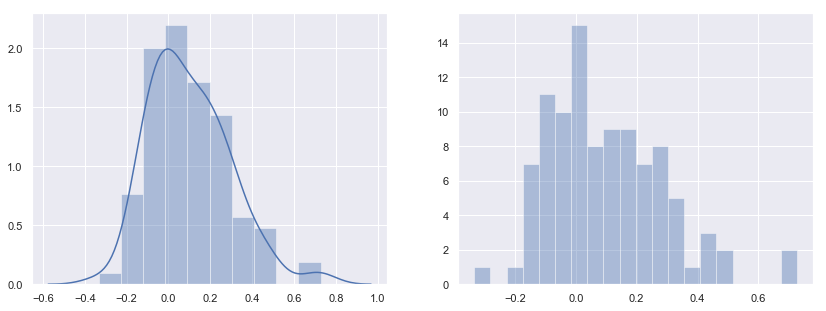

**Grammaticality**

39bc958bd11a0bb2abff646b858b577ae8a33cbff471f0f78b6dad63b5889bfa
4ee1a47c46b42bc23a5727804c7275b94421408f0aeb6ca1d18fdcbd302b3e20
5df775673ca8c2a5a3392233a1a6007a7d08bfcc7bacfc4a61fffd52b86556fd
79e5c3f681b4dd272f3467d86399dae17a57973b465e9b33e8e48a7734898b1e
bbacac2968afef9583d767225d1faf928d1f10ecac8dad1a090c77db730d2e94


'max  : 0.7272727272727274'

'mean : 0.07499452092684854'

'stdev: 0.19228988061495628'

'min  : -0.30434782608695654'

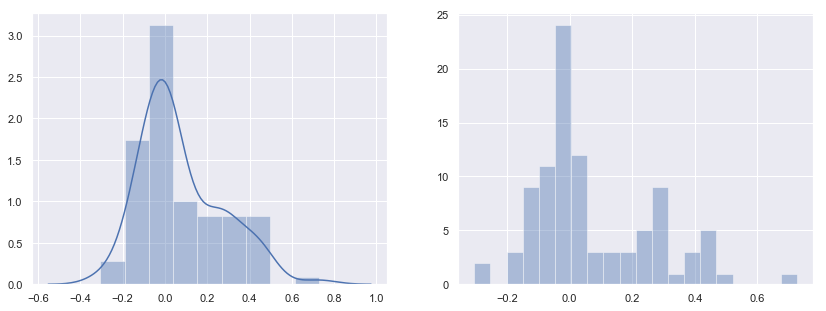

**Merging**

'max  : 0.2758620689655171'

'mean : 0.02272205097445598'

'stdev: 0.095333752318243'

'min  : -0.1851851851851852'

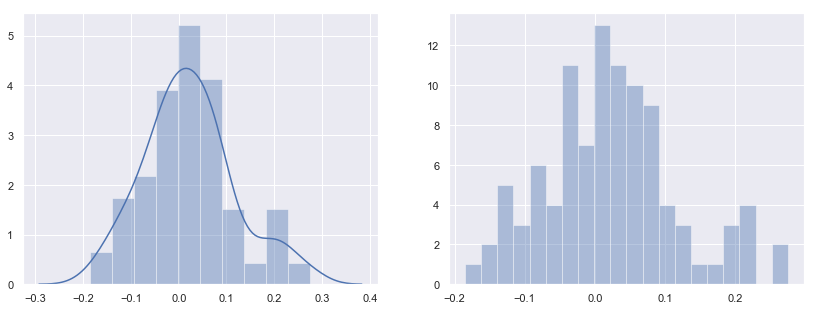

In [16]:
fleiss_kappa(fth_selec, "Faithfulness")
fleiss_kappa(grm_selec, "Grammaticality")
fleiss_kappa(mrg_selec, "Merging")